In [1]:
from gymnasium import Env
from gymnasium.spaces.box import Box
import numpy as np
import random
from stable_baselines3 import SAC
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.noise import NormalActionNoise
import wandb
from wandb.integration.sb3 import WandbCallback
import os
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import pickle
import warnings
import math
warnings.filterwarnings("ignore")

# Siguientes pasos
* Ir cambiando estado inicial (primero posición y luego también velocidad y corriente)
* Añadir datos de este año
* Cambiar reward a corriente

In [164]:
class BobinaEnv(Env):
  """
  Custom Gym Environment for the Hybrid Electromagnetic Suspension, considering just one coil.
  """
  def __init__(self, masa_pod = 250, airgap = 16.3, duration = 10):
    # Actions: Voltage applied to the coil
    self.action_space = Box(low=np.array([-100]), high = np.array([100]), dtype=np.float32)
    # Observations: Airgap to the ceiling, velocity, distance to the objective, current of the coil
    self.observation_space = Box(low=np.array([9, -np.inf, -10, -45]), high = np.array([22.5, np.inf, 10, 45]), dtype=np.float32)
    # Initial parameters
    self.state = np.array([airgap, 0, airgap - 16.3, 0])
    self.airgapinicial = airgap
    self.duration = duration
    self.timeleft = duration
    self.crash = False
    self.masa_pod = masa_pod
    self.bobina = Bobina(masa_pod = self.masa_pod, airgap = self.airgapinicial)
    self.steps = []
    self.airgap = airgap
    self.distancia = 0
    self.velocidad = 0
    self.current = 0


  def step(self, action):
    # Apply action
    self.state, self.crash = self.bobina.step(action[0])
    self.airgap, self.velocidad, self.distancia, self.current = self.state

    # Reduce the time of the experiment
    self.timeleft -= 0.001

    # Calculate reward
    reward = -abs(self.distancia)

    """if self.airgap >= 23: reward = -500
    elif self.airgap <= 10: reward = -500
    else: reward = -abs(self.current)"""

    # Check if experiment is done
    if self.timeleft <= 0:
      truncated = True
    else: truncated = False
    # Set placeholder for info
    info = {}
    # Only if we implemented the crash
    if self.crash:
      reward = - 50000
      terminated = True
    else:
      terminated = False
    self.steps.append(self.state)
    return self.state, reward, terminated, truncated, info


  def render(self, yes = "yes"):
    # create data
    x = list(range(0,len(self.steps)))
    y = [step[0] for step in self.steps]
    objective = [16.3]*len(self.steps)

    # plot lines
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax.tick_params(axis='x', colors='white')    #setting up X-axis tick color to red
    ax.tick_params(axis='y', colors='white')  #setting up Y-axis tick color to black

    plt.plot(x, y, label = "States")
    plt.plot(x, objective, label = "Objective")
    plt.legend()
    plt.show()

  def reset(self, seed = 0):
    # Reset experiment choosing randomly the start (ceiling or floor)
    airgap = random.choice([9, 22.5])
    self.state = self.observation_space.sample()
    self.airgap, self.velocidad, self.distancia, self.current = self.state
    self.bobina = Bobina(masa_pod = self.masa_pod, airgap = self.airgap)
    self.bobina.velocidad = [self.velocidad]
    self.bobina.aceleracion = [random.choice(list(range(-50, 50, 2)))/10]
    # Reset time
    self.timeleft = self.duration
    self.crash = False
    self.steps = []
    return self.state, seed

In [111]:
class Bobina():
  """ 
  Coil model for the Hybrid Electromagnetic Suspension
  """
  def __init__(self, masa_pod = 250, airgap = 22.5):
    self.masa_pod = masa_pod
    self.airgap = airgap
    self.aceleracion = []
    self.velocidad = []
    mat = scipy.io.loadmat('./coil/hems.mat')
    self.hems = mat["hems"][0][0]
    self.airgaps = self.hems[0][0]
    self.currents = self.hems[1][0]
    self.force_vertical = pickle.load(open("./coil/mlp_vertical.pkl", 'rb'))
    self.flux = self.hems[3]
    self.force_horizontal = self.hems[4]
    self.inductance = pickle.load(open("./coil/rf_inductance.pkl", 'rb'))
    self.resistance = self.hems[6][0][0]
    self.min_distance = 9
    self.max_distance = 22.5
    self.airgapinicial = airgap
    self.crash = False
    self.current = 0
    self.steps_RL = []

  def integral(self, lista, h = 1):
    return sum(h*(lista[i]+lista[i+1])/2 for i in range(len(lista)-1))

  def RL(self, airgap, target_voltage, temperature):
    # Resistance-Inductance circuit

    # Get resistance of the coil
    R = self.R(current = self.current, temperature = temperature)   
    V = target_voltage
    I = self.current
    L = self.L(airgap = airgap, current = self.current)
    dIdt = ((V/R) - I)/(L/R)                                      
    self.steps_RL.append(dIdt)                                   
    current = self.integral(self.steps_RL, h = 0.001)                          
    return current                                                  

  def R(self, current, temperature):
    return self.resistance                                         

  def L(self, airgap, current):
    # Return predicted inductance
    return float(self.inductance.predict(np.array([[airgap, current]]))[0])

  def vertical_force(self, airgap, target_voltage, temperature):
    # Get current from RL circuit
    I = self.RL(airgap = airgap, target_voltage = target_voltage, temperature = temperature) 
    
    # Clip result
    if I > 45:
      I = 45
    elif I < -45:
      I = -45
    self.current = I
    # Get vertical force from 
    FI = self.FI_vertical(airgap = airgap, current = I)                    
    return FI, I


  def FI_vertical(self, airgap, current):
    # Return predicted vertical force
    return float(self.force_vertical.predict(np.array([[airgap, current]])))    


  def next_airgap(self, masa_pod, vertical_force, verbose = False):
    # Devide the mass of the pod by 4 coils
    masa = masa_pod/4  
    # Calculate weight
    peso = masa * 9.8    
    # Get total force                                                       
    fuerza = peso - vertical_force
    if verbose: print("Fuerza resultante: ", fuerza)   
    # Calculate acceleration                                     
    aceleracion = fuerza/masa
    if verbose: print("Aceleración: ", aceleracion)                                         
    self.aceleracion.append(aceleracion)       
    # Calculate velocity                                
    velocidad = self.integral(self.aceleracion, 0.001)
    if verbose: print("Integral primera (velocidad): ", velocidad)                          
    self.velocidad.append(velocidad)               
    # Calculate position (x1000 as to transform from m to mm)                            
    posicion = self.airgapinicial + self.integral(self.velocidad, 0.001)*1000 
    if verbose: print("Integral segunda (posición): ", posicion)

    # Clip position
    if posicion > self.max_distance:
      airgap = self.max_distance
      self.aceleracion = [0]
      self.velocidad = [0]  
      #self.crash = True     
      self.airgapinicial = self.max_distance                                               
    elif posicion < self.min_distance:
      airgap = self.min_distance
      self.aceleracion = [0]
      self.velocidad = [0]
      #self.crash = True
      self.airgapinicial = self.min_distance
    else: airgap = posicion
    return airgap, velocidad

  def step(self, target_voltage, verbose = False):
    # Calculate vertical force and current
    vertical_force, self.current = self.vertical_force(airgap = self.airgap, target_voltage = target_voltage, temperature = 40)
    if verbose: print("Fuerza vertical: ", vertical_force)
    # Calculate next airgap and velocity
    self.airgap, velocidad = self.next_airgap(self.masa_pod, vertical_force, verbose = verbose)
    #noise = np.random.normal(0,0.5)
    #self.airgap = self.airgap + noise     
    return (np.float32(self.airgap), np.float32(velocidad), np.float32(self.airgap - 16.3), np.float32(self.current)), self.crash

In [131]:
run = wandb.init(
    project="1gdlcomplex",
    sync_tensorboard=True,
    monitor_gym=True,
)

SAC_43/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
SAC_43/rollout/ep_len_mean,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
SAC_43/rollout/ep_rew_mean,▁▁▃▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████
SAC_43/time/fps,█████▆▆▃▃▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
SAC_43/train/actor_loss,▅█▆▅▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
SAC_43/train/critic_loss,▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁
SAC_43/train/ent_coef,█▄▄▅▃▃▅▃▃▃▅▂▃▃▃▂▂▃▃▂▃▂▂▃▃▂▄▃▂▂▁▁
SAC_43/train/ent_coef_loss,▄█▆▇▃▃▅▄▄▃▄▆▆▄▆▃▇▅▃▆▄▂▆▅▅▄▃▅▃▁▅▄
SAC_43/train/learning_rate,███▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
global_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇████████████████████
rollout/ep_len_mean,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [159]:
# Create log dir
log_dir = "1gdlcomplex/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = BobinaEnv( duration = 4 )
env = Monitor(env, log_dir)

In [133]:
from typing import Callable

def linear_schedule(initial_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func

# para el critic , qf=[400, 300], para el actor pi=[300, 200]
policy_kwargs = dict(net_arch=dict(pi=[8, 8], qf=[256, 256]))
model = SAC("MlpPolicy", env,learning_rate = linear_schedule(0.001),  policy_kwargs=policy_kwargs, verbose=1, tensorboard_log=log_dir)

Using cpu device
Wrapping the env in a DummyVecEnv.


In [160]:

MODEL_PATH = f"models/sac8x8h9.3/model.zip"

# Create and wrap the environment
env = BobinaEnv(duration = 4)

# Load the trained agent
model = SAC.load(MODEL_PATH, env=env, learning_rate = linear_schedule(0.0001))

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [161]:
# Create checkpoint callback
checkpoint_callback = CheckpointCallback(
    save_freq=10000, save_path=log_dir, name_prefix="rl_sac_1gdlcomplex"
)

In [162]:
# Train the agent
model.learn(total_timesteps=1250000,
    callback=[
        checkpoint_callback,
        WandbCallback(
            gradient_save_freq=10000,
            model_save_path=f"models/sac8x8h9.3",
            model_save_freq=10000,
            verbose=2,
        ),
    ],
)

wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Logging to 1gdlcomplex/SAC_50


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 4e+03     |
|    ep_rew_mean     | -2.58e+03 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 47        |
|    time_elapsed    | 335       |
|    total_timesteps | 16004     |
| train/             |           |
|    actor_loss      | 17.9      |
|    critic_loss     | 0.114     |
|    ent_coef        | 0.023     |
|    ent_coef_loss   | -2.58     |
|    learning_rate   | 9.87e-05  |
|    n_updates       | 1129081   |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 4e+03     |
|    ep_rew_mean     | -6.63e+03 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 47        |
|    time_elapsed    | 675       |
|    total_timesteps | 32008     |
| train/             |           |
|    actor_loss      | 111       |
|    critic_loss    

KeyboardInterrupt: 

In [73]:
episodes = 3
state, seed = env.reset()
for episode in range(1, episodes+1):
    state, seed = env.reset()
    done = False
    score = 0
    while not done:
        action = env.action_space.sample()
        n_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))

Episode:1 Score:-1981494.4585288865
Episode:2 Score:-1979754.8377862521
Episode:3 Score:-1983431.8486917282


In [109]:
b = Bobina()
b.airgap = 9

In [108]:
b.step(100)

((20.00214, -0.10582279, 3.7021403, 45.0), False)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Time predict 3.0502686500549316
Time model 46.93717360496521
Episode reward -404.88558814674616
[array([-100.], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([81.21596], dtype=float32), array([-26.800224], dtype=float32), array([-67.369156], dtype=float32), array([-30.743668], dtype=float32), array([-9.694199], dtype=float32), array([-19.444923], dtype=float32), arra

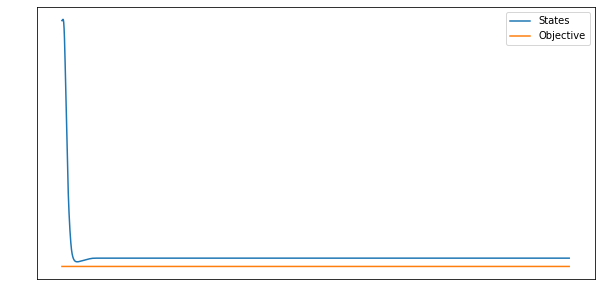

Time predict 3.0561487674713135
Time model 43.54526495933533
Episode reward -414.579052593559
[array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([79.3573], dtype=float32), array([9.326973], dtype=float32), array([-68.48044], dtype=float32), array([-56.493614], dtype=float32), array([14.117882], dtype=float32), array([21.705162], dtype=float32), array([-33.38417], dtype=float32), array([-58.608734], dtype=float32), array([-48.823

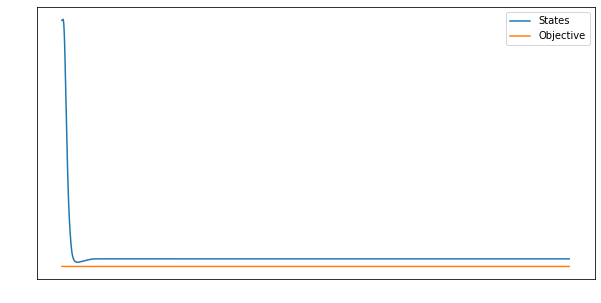

Time predict 3.1243784427642822
Time model 44.38002920150757
Episode reward -584.8446271307766
[array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dtype=float32), array([98.57109], dt

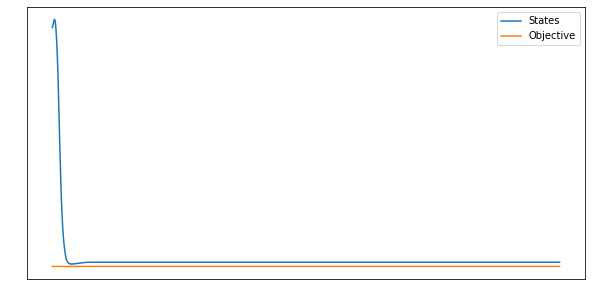

Time predict 3.205517053604126
Time model 45.336905002593994
Episode reward -406.09457176033175
[array([-100.], dtype=float32), array([-99.999985], dtype=float32), array([-99.99995], dtype=float32), array([-99.9998], dtype=float32), array([-99.99932], dtype=float32), array([-99.9977], dtype=float32), array([-99.992546], dtype=float32), array([-99.9766], dtype=float32), array([-99.92617], dtype=float32), array([-99.76203], dtype=float32), array([-99.21386], dtype=float32), array([-95.298645], dtype=float32), array([-58.270096], dtype=float32), array([30.60054], dtype=float32), array([51.987747], dtype=float32), array([18.50721], dtype=float32), array([-13.78595], dtype=float32), array([-7.345871], dtype=float32), array([15.629349], dtype=float32), array([21.901062], dtype=float32), array([11.069763], dtype=float32), array([2.0974426], dtype=float32), array([4.738022], dtype=float32), array([11.291359], dtype=float32), array([12.269127], dtype=float32), array([8.4114685], dtype=float32),

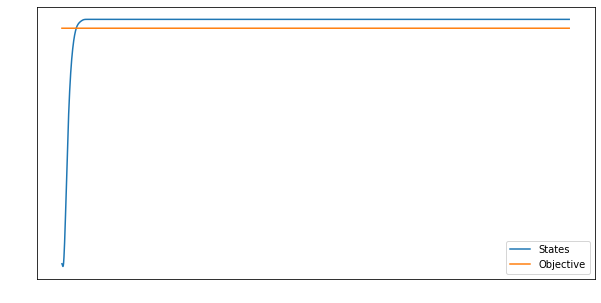

Time predict 3.1072027683258057
Time model 44.26220345497131
Episode reward -704.4634971078485
[array([98.57109], dtype=float32), array([-100.], dtype=float32), array([-100.], dtype=float32), array([-100.], dtype=float32), array([-100.], dtype=float32), array([-100.], dtype=float32), array([-100.], dtype=float32), array([-100.], dtype=float32), array([-100.], dtype=float32), array([-100.], dtype=float32), array([-100.], dtype=float32), array([-100.], dtype=float32), array([-100.], dtype=float32), array([-100.], dtype=float32), array([-100.], dtype=float32), array([-100.], dtype=float32), array([-100.], dtype=float32), array([-100.], dtype=float32), array([-100.], dtype=float32), array([-100.], dtype=float32), array([-100.], dtype=float32), array([-100.], dtype=float32), array([-100.], dtype=float32), array([-100.], dtype=float32), array([-100.], dtype=float32), array([-100.], dtype=float32), array([-100.], dtype=float32), array([-100.], dtype=float32), array([-100.], dtype=float32), ar

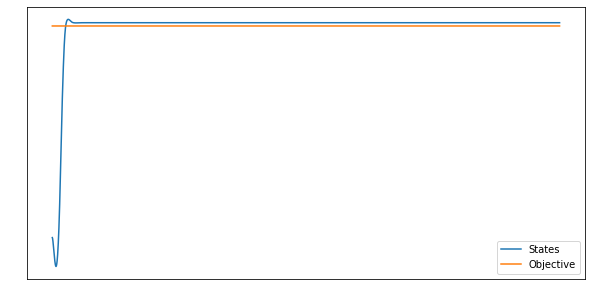

In [166]:
import numpy as np
import torch as th
import time

MODEL_PATH = f"models/sac8x8h9.3/model.zip"

# Create and wrap the environment
env = BobinaEnv(duration = 4)

# Load the trained agent
model = SAC.load(MODEL_PATH, env=env, learning_rate = 0.00001)

# Evaluate the agent
for i in range(5):
    obs, seed = env.reset()
    done = False
    episode_reward = 0
    velocidad = 0
    current = 0
    observations = []
    noises = []
    error = obs -16.3
    timepredict = 0
    timemodel = 0
    obs, velocidad, error, current = obs
    while not done:
        #noise = random.uniform(-1, 1)
        #obs = obs + noise
        observations.append(obs)
        #noises.append(noise)
        t1 = time.time()
        action, _states = model.predict(np.array([obs, velocidad, error, current]), deterministic=True)
        t2 = time.time()
        #print(action)
        #if env.airgap > 10.1: action = max(action, [-50])
        #print(action)
        t3 = time.time()
        state, reward, terminated, truncated, info = env.step(np.array(action))
        t4 = time.time()
        obs, velocidad, error, current = state
        done = truncated or terminated
        episode_reward += reward
        timepredict += t2 - t1
        timemodel += t4 - t3
        noises.append(action)
    print("Time predict", timepredict)
    print("Time model", timemodel)
    print("Episode reward", episode_reward)
    print(noises)
    env.render("yes")

In [10]:
run.id

NameError: name 'run' is not defined

In [167]:
import torch as th

from stable_baselines3 import SAC

#import onnx
import onnxruntime as ort
import numpy as np


class OnnxablePolicy(th.nn.Module):
    def __init__(self, actor: th.nn.Module):
        super().__init__()
        # Removing the flatten layer because it can't be onnxed
        self.actor = th.nn.Sequential(
            actor.latent_pi,
            actor.mu,
            # For gSDE
            # th.nn.Hardtanh(min_val=-actor.clip_mean, max_val=actor.clip_mean),
            # Squash the output
            th.nn.Tanh(),
        )

    def forward(self, observation: th.Tensor) -> th.Tensor:
        # NOTE: You may have to process (normalize) observation in the correct
        #       way before using this. See `common.preprocessing.preprocess_obs`
        return self.actor(observation)


# Example: model = SAC("MlpPolicy", "Pendulum-v1")
model = SAC.load(f"models/sac8x8h9.3/model.zip", device="cpu")
onnxable_model = OnnxablePolicy(model.policy.actor)

observation_size = model.observation_space.shape
dummy_input = th.randn(1, *observation_size)
th.onnx.export(
    onnxable_model,
    dummy_input,
    "./ONNX/1gdlComplexH98x8.onnx",
    opset_version=9,
    input_names=["input"],
)

##### Load and test with onnx

import onnxruntime as ort
import numpy as np

onnx_path = "./ONNX/1gdlComplexH98x8.onnx"

observation = np.zeros((1, *observation_size)).astype(np.float32)
ort_sess = ort.InferenceSession(onnx_path)
action = ort_sess.run(None, {"input": observation})

============== Diagnostic Run torch.onnx.export version 2.0.0+cpu ==============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



: 

In [12]:
model.policy

SACPolicy(
  (actor): Actor(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (latent_pi): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=8, bias=True)
      (3): ReLU()
    )
    (mu): Linear(in_features=8, out_features=1, bias=True)
    (log_std): Linear(in_features=8, out_features=1, bias=True)
  )
  (critic): ContinuousCritic(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (qf0): Sequential(
      (0): Linear(in_features=5, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=1, bias=True)
    )
    (qf1): Sequential(
      (0): Linear(in_features=5, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
   

In [ ]:
# See "ONNX export" for imports and OnnxablePolicy
jit_path = "1gdlComplex.pt"

# Trace and optimize the module
traced_module = th.jit.trace(onnxable_model.eval(), dummy_input)
frozen_module = th.jit.freeze(traced_module)
frozen_module = th.jit.optimize_for_inference(frozen_module)
th.jit.save(frozen_module, jit_path)

##### Load and test with torch

import torch as th

dummy_input = th.randn(1, *observation_size)
loaded_module = th.jit.load(jit_path)
action_jit = loaded_module(dummy_input)